# TP EPITA - 2. Réaffectation des individus dans les groupes avec variables actives

Ce notebook contient notre code pour la 2e partie du TP de Kantar. Notre groupe est constitué de :
- Alexandre Devaux-Rivière
- Valentin San
- Maël Reynaud

# Classification sur features orange

Dans cette partie, à partir des variables oranges utilsées pour construire les clusters, on va établir un algorithme permettant de réaffecter les individus dans les clusters pré-définis, en essayant de minimiser le nombre de variables utilisées en maximisant le pourcentage de bon classement, pour ainsi découvrir des Golden Questions.

In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

pd.set_option("display.max_columns", None)

%matplotlib inline

/home/alex/Kantar_projects/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/orange_with_labels.csv', sep=';', index_col=0)
df.head(10)

,A11,A9_1_slice,A9_2_slice,A9_3_slice,A9_4_slice,A9_5_slice,A9_6_slice,A9_7_slice,A9_8_slice,A9_9_slice,A9_10_slice,A9_11_slice,A9_12_slice,A9_13_slice,A9_14_slice,A9_15_slice,A9_16_slice,A10_1_slice,A10_2_slice,A10_3_slice,A10_4_slice,A10_5_slice,A10_6_slice,A10_7_slice,A10_8_slice,A11_1_slice,A11_2_slice,A11_3_slice,A11_4_slice,A11_5_slice,A11_6_slice,A11_7_slice,A11_8_slice,A11_9_slice,A11_10_slice,A11_11_slice,A11_12_slice,A11_13_slice,cluster
0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1
2,1,3,2,2,2,3,2,2,2,2,2,2,3,2,3,2,2,2,2,3,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
3,1,1,2,2,2,3,2,3,2,1,2,1,3,3,1,2,3,2,2,3,2,2,3,2,3,2,2,1,2,1,2,3,3,3,2,2,1,2,0
4,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
5,1,3,4,3,3,3,3,3,3,4,4,3,3,3,4,3,3,2,2,3,2,3,2,2,3,2,2,2,3,2,2,2,3,3,2,2,3,3,3
6,1,4,3,3,2,2,3,1,3,1,2,2,3,2,3,3,2,2,2,2,2,2,2,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0
7,1,1,2,2,2,3,2,2,2,1,1,1,1,2,2,2,2,2,1,3,2,2,4,2,2,2,1,2,2,1,2,2,2,1,2,2,2,1,1
8,1,2,2,2,2,3,2,3,3,2,2,2,3,4,2,2,3,1,1,3,2,2,2,1,2,2,2,1,4,2,1,2,3,3,3,2,2,2,0
9,1,1,3,4,2,3,1,2,2,3,2,2,2,2,1,2,3,1,1,2,1,1,4,4,2,1,1,1,1,1,1,2,1,2,2,2,3,3,1


Enumérons les colonnes faisant référence aux questions prises en compte pour la partie orange.

In [3]:
df.columns

Index(['A11', 'A9_1_slice', 'A9_2_slice', 'A9_3_slice', 'A9_4_slice',
       'A9_5_slice', 'A9_6_slice', 'A9_7_slice', 'A9_8_slice', 'A9_9_slice',
       'A9_10_slice', 'A9_11_slice', 'A9_12_slice', 'A9_13_slice',
       'A9_14_slice', 'A9_15_slice', 'A9_16_slice', 'A10_1_slice',
       'A10_2_slice', 'A10_3_slice', 'A10_4_slice', 'A10_5_slice',
       'A10_6_slice', 'A10_7_slice', 'A10_8_slice', 'A11_1_slice',
       'A11_2_slice', 'A11_3_slice', 'A11_4_slice', 'A11_5_slice',
       'A11_6_slice', 'A11_7_slice', 'A11_8_slice', 'A11_9_slice',
       'A11_10_slice', 'A11_11_slice', 'A11_12_slice', 'A11_13_slice',
       'cluster'],
      dtype='object')

## Processing des données

Contrairement à ce qu'on a fait dans la première partie, où on utilisait le poids associé à chaque utilisateur (pour combler réajuster le manque / le surplus de certaines populations) au niveau de notre modèle, ici on ne l'utilise pas car l'objectif de notre modèle est de s'étendre à de nouveau utilisateur, auquel on n'associerait pas de poids.


Dans notre contexte, scale les données n'a ici pas d'interet particulier du fait que les arbres de décision  ne sont pas influencés par l'échelle des caractéristiques. C'est seulement dans le cas où d'autres algorithmes seraient ajoutés par la suite.

In [4]:
X = df.drop(['cluster'], axis=1)
y = df['cluster']
features = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Nous procédons ensuite à la séparation de notre dataset en deux parties 80%/20%: entrainement (pour entrainer notre modèle) et test (pour évaluer ses performances sur des données / distributions non vues avant)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
print(X_train.shape)
print(X_test.shape)

(4000, 38)
(1000, 38)


## Entraînement et évaluation de notre modèle

Nous allons pour cette partie utiliser un *RandomForestClassifier*. Afin de trouver les meilleurs hyper paramètres possibles pour accroitre les performances du modèle, nous allons passer par l'utilisation de Optuna. Optuna repose sur des techniques avancées d'optimisation bayésienne, comme **TPE (Tree-structured Parzen Estimator)**, pour trouver les hyperparamètres optimaux de manière intelligente. Contrairement à des approches comme *GridSearchCV* ou *RandomizedSearchCV*, TPE utilise les informations des évaluations précédentes pour mieux guider l'exploration des espaces d'hyperparamètres.

Pour faire fonctionner l'optimisation, on a donc juste à fournir un espace de recherche pour les hyperparamètres et la métrique à optimiser.

Dans notre cas:
- l'espace de recherche est défini sur `n_estimators`, `min_samples_leaf`, `max_features`, `bootstrap`. On laissera les autres arguments RandomForestClassifier à leur valeur par défaut car d'après notre expérience ils sont déjà suffisamment bons.
- la métrique à optimiser: la moyenne de l'accuracy après une cross validation avec 5 splits.

In [7]:
def study_objective(trial):
    # Here are the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    clf = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    return np.mean(scores)

In [8]:
study = optuna.create_study(direction='maximize')
study.optimize(study_objective, n_trials=100)

[I 2025-01-24 20:55:08,077] A new study created in memory with name: no-name-452460da-78a8-43ba-87f4-f49464e6b67b
[I 2025-01-24 20:56:29,705] Trial 0 finished with value: 0.807 and parameters: {'n_estimators': 1032, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.807.
[I 2025-01-24 20:56:44,355] Trial 1 finished with value: 0.9272 and parameters: {'n_estimators': 1176, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.9272.
[I 2025-01-24 20:56:57,942] Trial 2 finished with value: 0.9082000000000001 and parameters: {'n_estimators': 1125, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.9272.
[I 2025-01-24 20:57:43,493] Trial 3 finished with value: 0.8914000000000002 and parameters: {'n_estimators': 990, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.9272.
[I 2025-01-24 20:57:57,669] Trial 4 finished

In [9]:
print("Best trial:")
trial = study.best_trial
print(f"├── Accuracy: {trial.value:.4f}")
print("└── Params: ")
for key, value in trial.params.items():
    print(f"    └── {key}: {value}")

Best trial:
├── Accuracy: 0.9324
└── Params: 
    └── n_estimators: 939
    └── min_samples_leaf: 1
    └── max_features: log2
    └── bootstrap: False


In [10]:
classifier_orange = RandomForestClassifier(**study.best_params, random_state=42)
classifier_orange.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=939,
                       random_state=42)

In [11]:
y_pred = classifier_orange.predict(X_test)
clean_accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {clean_accuracy:.2f}")
print(classification_report(y_test, y_pred))

Test accuracy: 0.92
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       423
           1       0.94      0.93      0.94       230
           2       0.96      0.81      0.88        63
           3       0.92      0.90      0.91       284

    accuracy                           0.92      1000
   macro avg       0.93      0.90      0.91      1000
weighted avg       0.92      0.92      0.92      1000



On obtient de très bons résultats de classification, ce qui est un très bon signe car cela veut dire que notre `RandomForestClassifier` modélise bien les relations entre les features pour chacun des clusters qu'on a choisi auparavant, autrement dit les clusters font sens.

Pour établir les goldens questions, il faut qu'on regarde l'importance accordée à chaque feature par le modèle.

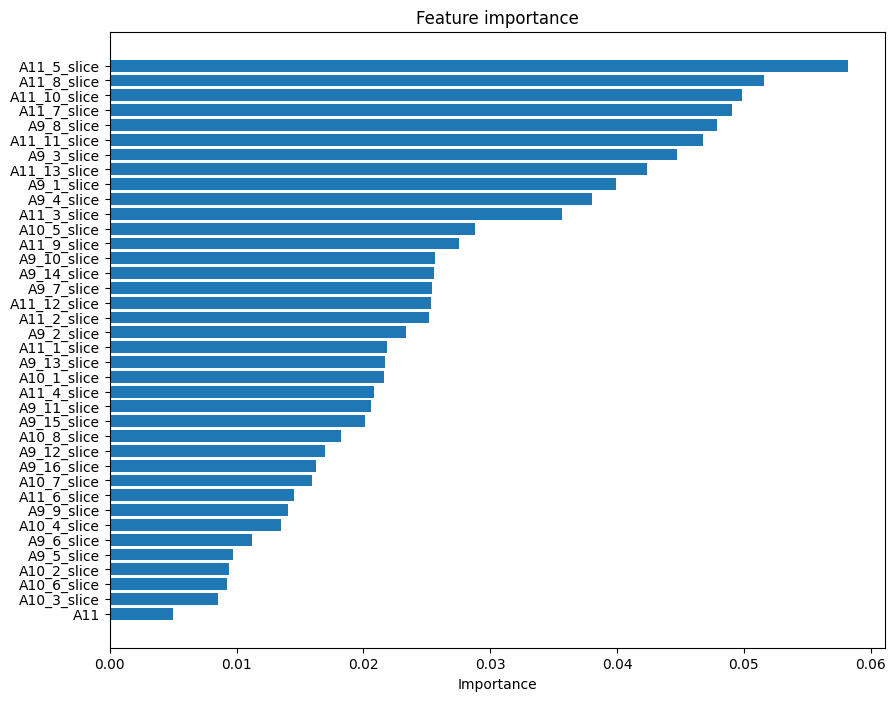

In [12]:
feature_importance = classifier_orange.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(features)), feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(len(features)), features[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.show()

Pour identifier les Goldens Questions, on va itérer et évaluer notre modèle en prenant en compte que certaines features, en faisant varier le seuil d'importance.  

In [13]:
nb_clusters = len(np.unique(y))

In [32]:
len_feature = len(feature_importance)
nb_features = []
metrics = {i: [] for i in range(nb_clusters + 1)}

# INVERSE ORDER SORT
sorted_idx = np.argsort(feature_importance)[::-1]


for nb in tqdm(range(1, len_feature)):
    nb_features.append(nb)
    selected_features = sorted_idx[:nb]
    sub_X_train = X_train[:, selected_features]
    sub_X_test = X_test[:, selected_features]

    sub_classifier = RandomForestClassifier(**study.best_params, random_state=42)
    sub_classifier.fit(sub_X_train, y_train)

    y_pred = sub_classifier.predict(sub_X_test)
    clf_report = classification_report(y_pred, y_test, output_dict=True, zero_division=0)

    for i in range(nb_clusters):
        metrics[i].append(clf_report[f'{i}']['f1-score'])
    metrics[nb_clusters].append(clf_report['weighted avg']['f1-score'])

100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


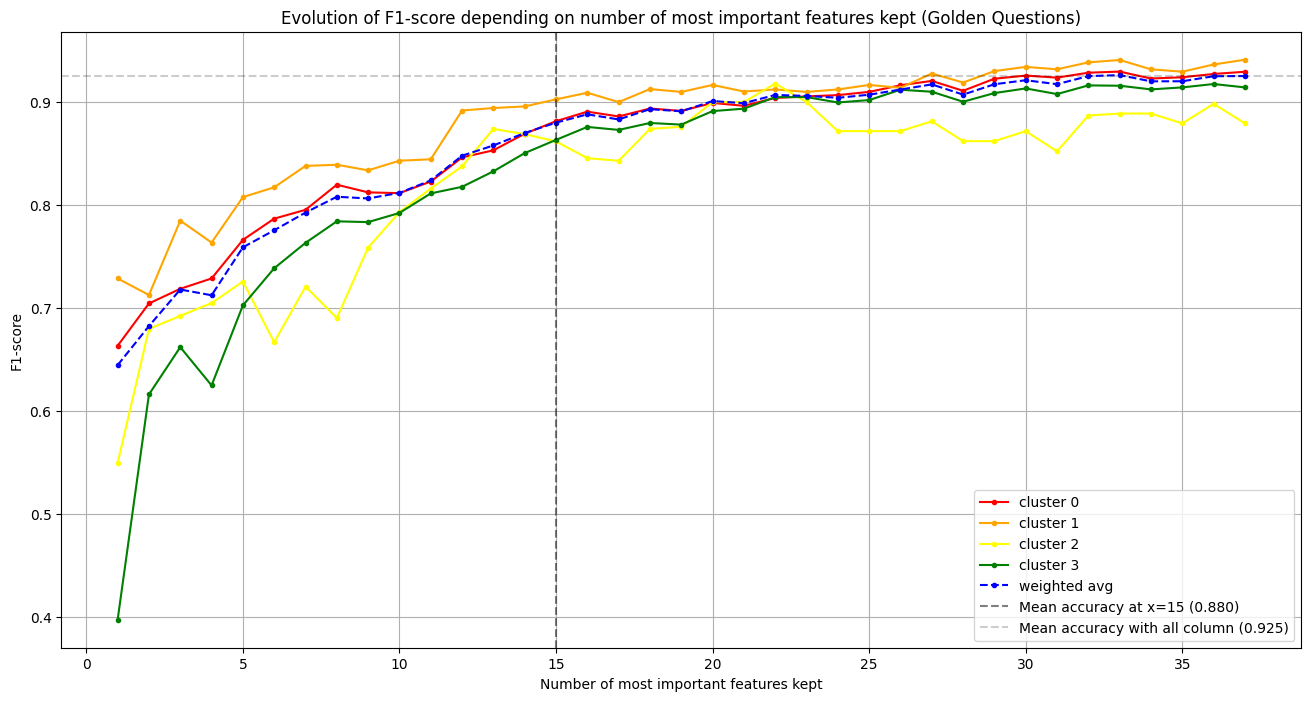

In [59]:
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "violet", "pink"]
mean_final_acc = metrics[nb_clusters][-1]
mean_15_acc = metrics[nb_clusters][14]

plt.figure(figsize=(16, 8))

for i in range(nb_clusters):
    plt.plot(nb_features, metrics[i], label=f"cluster {i}", color=colors[i], marker='.')

plt.plot(nb_features, metrics[nb_clusters], label="weighted avg", color="blue", marker='.', linestyle='--')
plt.title("Evolution of F1-score depending on number of most important features kept (Golden Questions)")

plt.axvline(x=15, color='black', linestyle='--', label=f'Mean accuracy at x=15 ({mean_15_acc:.3f})', alpha=0.5)
plt.axhline(y=mean_final_acc, color='black', linestyle='--', label=f'Mean accuracy with all column ({mean_final_acc:.3f})', alpha=0.2)

plt.xlabel("Number of most important features kept")
plt.ylabel("F1-score")
plt.grid(True)
plt.legend()

On remarque qu'en gardant à peu près les 15 questions qui ont le plus d'influence sur notre modèle, on arrive à avoir des résultats proches à ceux lorsqu'on a lorsque toutes les questions sont données (en effet seulement 4% d'accuracy de différence).

Avec moins de la moitié des questions (~40%) posées au client, on peut donc toujours bien arriver à les classifier!

Voici la liste des **15 goldens questions** pour la partie orange:

In [56]:
features[sorted_idx[:15]]

Index(['A11_5_slice', 'A11_8_slice', 'A11_10_slice', 'A11_7_slice',
       'A9_8_slice', 'A11_11_slice', 'A9_3_slice', 'A11_13_slice',
       'A9_1_slice', 'A9_4_slice', 'A11_3_slice', 'A10_5_slice', 'A11_9_slice',
       'A9_10_slice', 'A9_14_slice'],
      dtype='object')

# Classification sur features vertes

Dans cette partie, nous allons réaliser la même étude mais cette fois à partir des variables vertes les clusters. Nous allons doncnous concentrer sur l'exploitation des résultats plutôt que d'expliquer nos choix d'implémentation précédemment introduits.

In [60]:
df = pd.read_csv('../data/green_with_labels.csv', sep=';', index_col=0)
df.head(10)

,A11,A12,A13,A14,A4,A5,A5bis,A8_1_slice,A8_2_slice,A8_3_slice,A8_4_slice,B1_1_slice,B1_2_slice,B2_1_slice,B2_2_slice,B3,B4,B6,C1_1_slice,C1_2_slice,C1_3_slice,C1_4_slice,C1_5_slice,C1_6_slice,C1_7_slice,C1_8_slice,C1_9_slice,cluster
0,1,0,0,0,1,2.0,0.0,2,2,2,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,3
1,1,0,0,0,1,5.0,0.0,2,0,0,0,2,2,2,2,3,3,3,4,4,4,4,4,4,4,4,4,0
2,1,0,0,0,1,2.0,0.0,5,5,1,1,2,2,2,3,3,3,4,4,4,4,4,4,4,4,4,4,0
3,1,1,1,0,1,1.0,0.0,2,3,2,1,4,3,4,3,3,4,4,4,4,5,5,5,5,5,4,4,1
4,0,1,0,0,2,0.0,1.0,1,1,1,1,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4
5,1,0,0,0,1,2.0,0.0,0,1,0,0,3,3,4,4,4,4,4,5,5,5,5,5,5,5,5,5,1
6,1,0,0,0,1,1.0,0.0,4,2,0,0,2,2,3,3,4,4,4,5,5,5,5,5,5,5,5,5,1
7,1,0,1,0,1,2.0,0.0,8,4,10,10,2,3,2,3,2,2,2,3,2,2,1,3,1,3,3,2,3
8,1,0,1,0,3,0.0,4.0,1,1,1,0,4,4,4,4,3,3,3,4,4,5,5,5,5,5,5,5,4
9,1,0,0,0,1,2.0,0.0,3,3,1,1,3,3,3,3,3,4,4,4,4,5,5,4,5,5,5,4,1


In [61]:
df.columns

Index(['A11', 'A12', 'A13', 'A14', 'A4', 'A5', 'A5bis', 'A8_1_slice',
       'A8_2_slice', 'A8_3_slice', 'A8_4_slice', 'B1_1_slice', 'B1_2_slice',
       'B2_1_slice', 'B2_2_slice', 'B3', 'B4', 'B6', 'C1_1_slice',
       'C1_2_slice', 'C1_3_slice', 'C1_4_slice', 'C1_5_slice', 'C1_6_slice',
       'C1_7_slice', 'C1_8_slice', 'C1_9_slice', 'cluster'],
      dtype='object')

## Processing des données, et séparation du dataset en train / test splits

On rappelle que scale les données n'a ici pas d'interet particulier du fait que les arbres de décision ont une insensibilité aux échelles des variables. C'est seulement dans le cas où d'autres algorithmes seraient ajoutés par la suite.

In [62]:
X = df.drop(['cluster'], axis=1)
y = df['cluster']
features = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [64]:
print(X_train.shape)
print(X_test.shape)

(4000, 27)
(1000, 27)


## Apprentissage et évaluation d'un modèle *RandomForestClassifier*

In [65]:
def study_objective(trial):
    # Here are the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    clf = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(study_objective, n_trials=100)

[I 2025-01-24 22:12:49,421] A new study created in memory with name: no-name-76f74e59-3402-42e6-b622-f043325a4447
[I 2025-01-24 22:12:57,719] Trial 0 finished with value: 0.9342 and parameters: {'n_estimators': 592, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9342.
[I 2025-01-24 22:13:03,278] Trial 1 finished with value: 0.9278000000000001 and parameters: {'n_estimators': 629, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.9342.
[I 2025-01-24 22:13:12,224] Trial 2 finished with value: 0.9268000000000001 and parameters: {'n_estimators': 926, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9342.
[I 2025-01-24 22:13:18,116] Trial 3 finished with value: 0.9216000000000001 and parameters: {'n_estimators': 641, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9342.
[I 2025-01-24 22:13:22,862] 

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"├── Accuracy: {trial.value:.4f}")
print("└── Params: ")
for key, value in trial.params.items():
    print(f"    └── {key}: {value}")

In [ ]:
classifier_green = RandomForestClassifier(**study.best_params, random_state=42)
classifier_green.fit(X_train, y_train)

In [ ]:
y_pred = classifier_green.predict(X_test)
clean_accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {clean_accuracy:.2f}")
print(classification_report(y_test, y_pred))

On obtient aussi de très bons résultats de classification sur cette partie. Encore une fois, un `RandomForestClassifier` modélise bien les relations entre les features pour chacun des clusters qu'on a choisi auparavant, autrement dit les clusters font sens.

Pour établir les goldens questions, il faut qu'on regarde l'importance accordée à chaque feature par le modèle.

In [ ]:
feature_importance = classifier_green.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(features)), feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(len(features)), features[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importance')
plt.show()

Pour identifier les Goldens Questions, on va itérer et évaluer notre modèle en prenant en compte que certaines features, en faisant varier le seuil d'importance.  

In [59]:
nb_clusters = len(np.unique(y))

In [ ]:
thresholds = np.linspace(0.002, 0.03, 10)
nb_features = []
metrics = {i: [] for i in range(nb_clusters + 1)}

for thresh in tqdm(thresholds):
    selected_features = feature_importance > thresh
    nb_features.append(sum(selected_features))
    sub_X_train = X_train[:, selected_features]
    sub_X_test = X_test[:, selected_features]

    sub_classifier = RandomForestClassifier(**study.best_params, random_state=42)
    sub_classifier.fit(sub_X_train, y_train)

    y_pred = sub_classifier.predict(sub_X_test)
    clf_report = classification_report(y_pred, y_test, output_dict=True)

    for i in range(nb_clusters):
        metrics[i].append(clf_report[f'{i}']['f1-score'])
    metrics[nb_clusters].append(clf_report['weighted avg']['f1-score'])

In [ ]:
colors = ["red", "orange", "yellow", "green", "cyan", "blue", "violet", "pink"]

plt.figure(figsize=(16, 8))

for i in range(nb_clusters):
    plt.plot(nb_features, metrics[i], label=f"cluster {i}", color=colors[i], marker='o')

plt.plot(nb_features, metrics[nb_clusters], label="weighted avg", color=colors[-1], marker='o', linestyle='--')
plt.title("Evolution of F1-score depending on number of most important features kept (Golden Questions)")
plt.xlabel("Number of most important features kept")
plt.ylabel("F1-score")
plt.legend()

On remarque qu'en gardant à peu près les 25 features qui ont le plus d'influence sur notre modèle, on arrive à avoir des résultats similaires à ceux lorsqu'on a toutes les features en input.

Avec un peu plus que la moitié des questions posées au client, on peut donc toujours bien arriver à les classifier !